## Monocle3 Python

In [1]:
import os
import h5py
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
from py_monocle import learn_graph, order_cells
from py_monocle import compute_cell_states
from py_monocle import regression_analysis

In [2]:
ROOT_DIR = os.path.abspath("")
DATA_PATH = os.path.join(ROOT_DIR, "data", "processed_data.h5")

In [3]:
with h5py.File(DATA_PATH, "r") as f:
  umap = f["UMAP"][()]
  louvain = f["Louvain"][()]

#### Learn the trajectory graph

In [4]:
projected_points, mst, centroids = learn_graph(
  matrix=umap, clusters=louvain,
)

#### Pseudotime

In [5]:
pseudotime = order_cells(
  umap, centroids,
  mst=mst,
  projected_points=projected_points,
  root_cells=0,
)

#### Plot trajectory graph

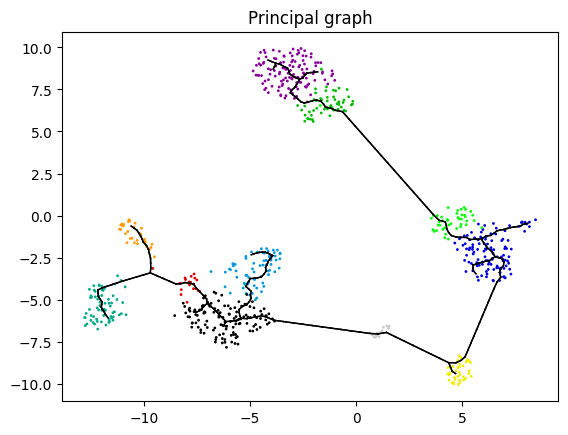

In [6]:
plt.title("Principal graph")
plt.scatter(umap[:, 0], umap[:, 1], c=louvain, s=1, cmap="nipy_spectral")

edges = np.array(mst.nonzero()).T
for edge in edges:
  plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.show()

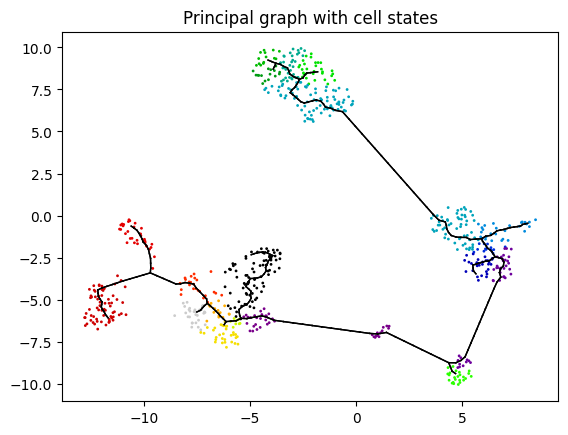

In [7]:
plt.title("Principal graph with cell states")
cell_states, _ = compute_cell_states(umap, centroids, mst)
plt.scatter(umap[:, 0], umap[:, 1], c=cell_states, s=1, cmap="nipy_spectral")
edges = np.array(mst.nonzero()).T
for edge in edges:
  plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.show()

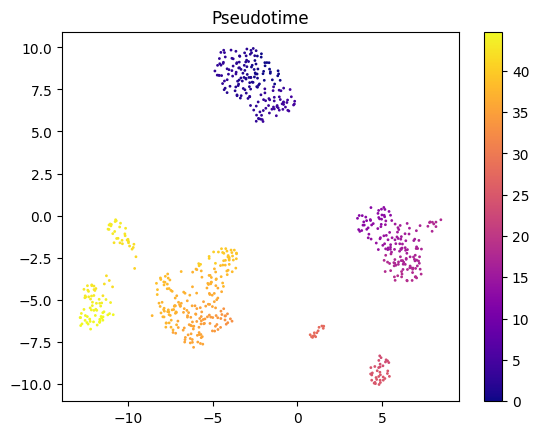

In [8]:
plt.title("Pseudotime")
plt.scatter(umap[:, 0], umap[:, 1], c=pseudotime, s=1, cmap="plasma")
plt.colorbar()
plt.show()

In [9]:
with h5py.File(DATA_PATH, "r") as f:
  R_pseudotime = f["pseudotime"][()]

  barcodes = [bc.decode() for bc in f["expression_matrix/barcodes"]]
  features = [ft.decode() for ft in f["expression_matrix/features"]]
  data = f["expression_matrix/data"][()]
  indices = f["expression_matrix/indices"][()]
  indptr = f["expression_matrix/indptr"][()]

expression_matrix = sparse.csr_matrix(
  (data, indices, indptr),
  shape=(len(barcodes), len(features))
)

In [10]:
np.random.seed(52)
rand_gene_indices = np.random.permutation(len(features))[:50]
gene_names = np.array(features)[rand_gene_indices]
expression_matrix = expression_matrix.tocsc()[:, rand_gene_indices]

In [11]:
pvals_matrix = regression_analysis(expression_matrix, pseudotime, cell_states)
pvals_matrix_R = regression_analysis(expression_matrix, R_pseudotime, cell_states)

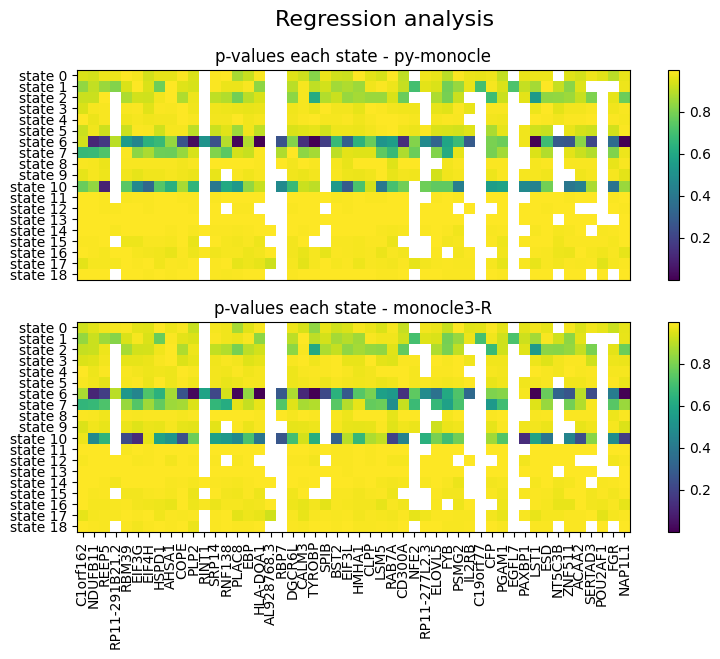

In [12]:
n_states = len(np.unique(cell_states))

fig = plt.figure(2, (10, 6))
fig.suptitle("Regression analysis", fontsize=16)
ax = plt.subplot(2, 1, 1)
s = ax.imshow(pvals_matrix)
ax.set_yticks(np.arange(n_states))
ax.set_yticklabels([f"state {i}" for i in range(n_states)])
ax.set_xticks([])
ax.set_title("p-values each state - py-monocle")
fig.colorbar(s)
ax = plt.subplot(2, 1, 2)
s = ax.imshow(pvals_matrix_R)
ax.set_yticks(np.arange(n_states))
ax.set_yticklabels([f"state {i}" for i in range(n_states)])
ax.set_xticks(np.arange(len(gene_names)))
ax.set_xticklabels(gene_names, rotation='vertical')
ax.set_title("p-values each state - monocle3-R")
fig.colorbar(s)
plt.show()